### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 642 (delta 126), reused 237 (delta 63), pack-reused 278
Receiving objects: 100% (642/642), 97.32 MiB | 35.11 MiB/s, done.
Resolving deltas: 100% (272/272), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=de8b55fb0e78aa50af3ce718070b3dc6818281b8488ff7e968cbf038f6996477
  Stored in directory: /tmp/pip-ephem-wheel-cache-qp3csmlp/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [6]:
from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, EqualHist
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import cv2
from tqdm import tqdm
import pickle

In [8]:
# import os
# from shutil import copyfile

# for i in range(1,21):
#   copyfile(DRIVE_PATH+'data/orto_detection/map1_1.txt', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_1.txt')
#   copyfile(DRIVE_PATH+'data/orto_detection/map1_2.txt', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_2.txt')
#   copyfile(DRIVE_PATH+'data/orto_detection/map1_3.txt', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_3.txt')

# for i in range(1,21):
#   copyfile(DRIVE_PATH+'data/raw/orto_parkings/map'+str(i)+'_1.png', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_1.png')
#   copyfile(DRIVE_PATH+'data/raw/orto_parkings/map'+str(i)+'_2.png', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_2.png')
#   copyfile(DRIVE_PATH+'data/raw/orto_parkings/map'+str(i)+'_3.png', DRIVE_PATH+'data/orto_detection/'+str(i)+'/map'+str(i)+'_3.png')

# Parkings

### Train ResNet50

In [20]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

In [21]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [22]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

Epoch 1/5
43/43 [==============================] - 8s 88ms/step - loss: 0.3689 - accuracy: 0.8935 - val_loss: 0.1205 - val_accuracy: 0.9767
Epoch 2/5
43/43 [==============================] - 2s 51ms/step - loss: 0.0348 - accuracy: 0.9929 - val_loss: 0.1070 - val_accuracy: 0.9852
Epoch 3/5
43/43 [==============================] - 2s 51ms/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.1052 - val_accuracy: 0.9809
Epoch 4/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0921 - val_accuracy: 0.9831
Epoch 5/5
43/43 [==============================] - 2s 51ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0942 - val_accuracy: 0.9873


### Detection

In [23]:
del data

In [24]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        EqualHist(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

In [25]:
processed_images_dict = {}

for i in range(1, 21):
  true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/orto_detection/'+str(i),
    output_folder_filepath=DRIVE_PATH+'data/orto_detection/'+str(i),
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
  )

  processed_images_dict[i] = processed_images


  0%|          | 0/3 [00:00<?, ?it/s]

346



 67%|██████▋   | 2/3 [00:29<00:14, 14.97s/it]

61
1150



100%|██████████| 3/3 [00:44<00:00, 14.70s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

681



 67%|██████▋   | 2/3 [00:29<00:14, 14.55s/it]

242
994



100%|██████████| 3/3 [00:43<00:00, 14.59s/it]

 33%|███▎      | 1/3 [00:14<00:29, 14.75s/it]

199
558



 67%|██████▋   | 2/3 [00:29<00:14, 14.69s/it]

1091



100%|██████████| 3/3 [00:44<00:00, 14.70s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.38s/it]

45



 67%|██████▋   | 2/3 [00:28<00:14, 14.39s/it]

310



100%|██████████| 3/3 [00:43<00:00, 14.43s/it]

297




 33%|███▎      | 1/3 [00:14<00:28, 14.35s/it]

85



 67%|██████▋   | 2/3 [00:28<00:14, 14.34s/it]

254
464



100%|██████████| 3/3 [00:43<00:00, 14.42s/it]

 33%|███▎      | 1/3 [00:14<00:29, 14.53s/it]

274
568



 67%|██████▋   | 2/3 [00:29<00:14, 14.54s/it]

708



100%|██████████| 3/3 [00:43<00:00, 14.66s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.41s/it]

111
432



 67%|██████▋   | 2/3 [00:29<00:14, 14.46s/it]

806



100%|██████████| 3/3 [00:43<00:00, 14.55s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

374



 33%|███▎      | 1/3 [00:14<00:28, 14.42s/it]

906



 67%|██████▋   | 2/3 [00:29<00:14, 14.51s/it]

967



100%|██████████| 3/3 [00:43<00:00, 14.62s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.43s/it]

221
558



 67%|██████▋   | 2/3 [00:29<00:14, 14.49s/it]

1178



100%|██████████| 3/3 [00:43<00:00, 14.63s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.34s/it]

156
637



 67%|██████▋   | 2/3 [00:28<00:14, 14.41s/it]

1606



100%|██████████| 3/3 [00:44<00:00, 14.79s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.25s/it]

121



 67%|██████▋   | 2/3 [00:28<00:14, 14.32s/it]

382
1078



100%|██████████| 3/3 [00:43<00:00, 14.47s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.39s/it]

271



 67%|██████▋   | 2/3 [00:28<00:14, 14.43s/it]

301
628



100%|██████████| 3/3 [00:43<00:00, 14.50s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

837



 33%|███▎      | 1/3 [00:14<00:29, 14.71s/it]

690



 67%|██████▋   | 2/3 [00:29<00:14, 14.67s/it]

790



100%|██████████| 3/3 [00:43<00:00, 14.64s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.46s/it]

276
1293



 67%|██████▋   | 2/3 [00:29<00:14, 14.70s/it]

821



100%|██████████| 3/3 [00:44<00:00, 14.79s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

438



 33%|███▎      | 1/3 [00:14<00:28, 14.48s/it]

820



 67%|██████▋   | 2/3 [00:29<00:14, 14.54s/it]

1319



100%|██████████| 3/3 [00:44<00:00, 14.68s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.33s/it]

138



 67%|██████▋   | 2/3 [00:28<00:14, 14.36s/it]

305
476



100%|██████████| 3/3 [00:43<00:00, 14.42s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.44s/it]

189
474



 67%|██████▋   | 2/3 [00:28<00:14, 14.45s/it]

736



100%|██████████| 3/3 [00:43<00:00, 14.50s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.50s/it]

184
626



 67%|██████▋   | 2/3 [00:29<00:14, 14.61s/it]

838



100%|██████████| 3/3 [00:44<00:00, 14.70s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.38s/it]

198
664



 67%|██████▋   | 2/3 [00:28<00:14, 14.45s/it]

916



100%|██████████| 3/3 [00:43<00:00, 14.57s/it]

 33%|███▎      | 1/3 [00:14<00:28, 14.37s/it]

268
557



 67%|██████▋   | 2/3 [00:28<00:14, 14.43s/it]

880



100%|██████████| 3/3 [00:43<00:00, 14.51s/it]


In [46]:
with open(DRIVE_PATH+'data/orto_detection/processed_images_dict.pickle', 'wb') as f:
  pickle.dump(processed_images_dict, f)

In [48]:
with open(DRIVE_PATH+'data/orto_detection/processed_images_dict.pickle', 'rb') as f:
  processed_images_dict = pickle.load(f)

In [51]:
# processed_images_dict[1][0][1]
# plt.imshow(processed_images_dict[1][0][0])
# len(processed_images_dict[1][0][1])

120

### Parkings

In [ ]:
EPS = 150
MIN_SAMPLES = 3

for i in range(1,2):

  for j in range(1, 3):

    image = processed_images_dict[i][j][0]
    bnd_boxes


# Clusters

## Boxes central points

In [ ]:
points_x = list(map(lambda x: x[0] + 64, bnd_boxes))
points_y = list(map(lambda x: x[5] + 64, bnd_boxes))

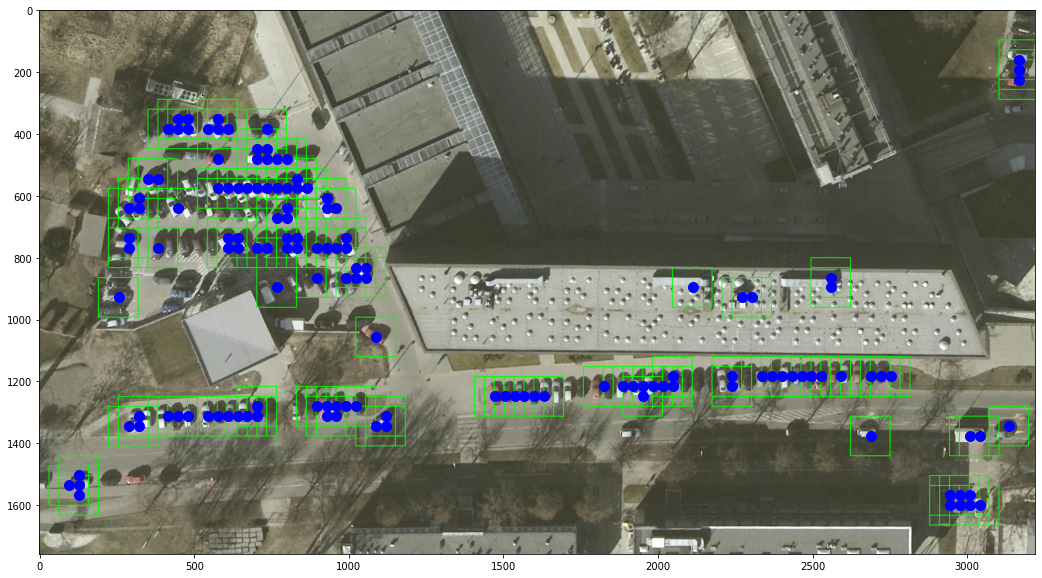

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.scatter(points_x, points_y, c='blue', s=100)
plt.show()

## Clusters

In [ ]:
clustering = DBSCAN(eps=100, min_samples=3).fit(list(zip(points_x, points_y)))
# clustering = KMeans(n_clusters=int(len(points_x)/10), random_state=0).fit(list(zip(points_x, points_y)))


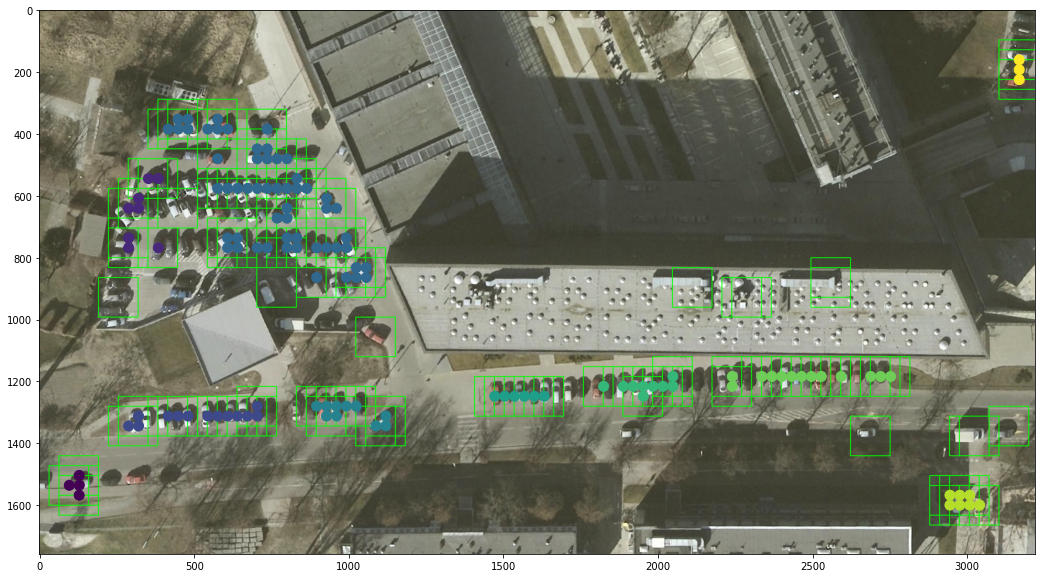

In [ ]:
colors = clustering.labels_

x_to_plot = []
y_to_plot = []
c_to_plot = []

for i in range(len(colors)):
    if colors[i] != -1:
        x_to_plot.append(points_x[i])
        y_to_plot.append(points_y[i])
        c_to_plot.append(colors[i])

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.scatter(x_to_plot, y_to_plot, c=c_to_plot, s=100)
plt.show()

## Clusters polygons

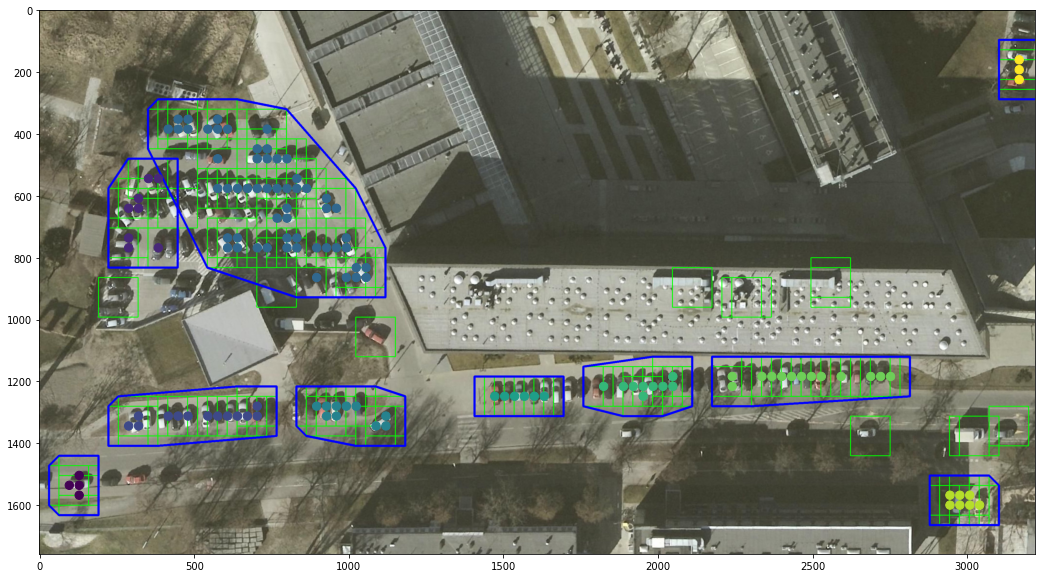

In [ ]:
df = pd.DataFrame(list(zip(points_x, points_y, colors, bnd_boxes)), columns=['x', 'y', 'c', 'box'])

def add_points(row):
    c = row['box']
    row['points'] = [
        (c[0], c[1]),
        (c[2], c[3]),
        (c[4], c[5]),
        (c[6], c[7])
        ]

    return row

df = df.apply(add_points, axis=1)

c_points = {}
for c in range(df['c'].max()+1):
    p_lists = df[df['c'] == c]['points'].to_list()
    c_points[c] = []
    for l in p_lists:
        c_points[c] = c_points[c] + l

image2 = image
hulls = []
for k, v in c_points.items():
    hull = cv2.convexHull(np.array(v))
    hulls.append(hull)
    image2 = cv2.drawContours(image2, [hull], -1, (0, 0, 255), 5)

plt.figure(figsize=(20,10))
plt.imshow(image2)
plt.scatter(x_to_plot, y_to_plot, c=c_to_plot, s=70)
plt.show()

## Mask

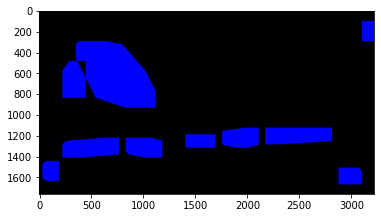

In [ ]:
mask = np.zeros_like(image)

cv2.fillPoly(mask, hulls, (0, 0, 255))

plt.imshow(mask, cmap='gray')
# cv2.imshow('mask', mask)

## Masks for 3 images

In [ ]:
def get_mask(image, bnd_boxes):

    points_x = list(map(lambda x: x[0] + 64, bnd_boxes))
    points_y = list(map(lambda x: x[5] + 64, bnd_boxes))

    clustering = DBSCAN(eps=100, min_samples=3).fit(list(zip(points_x, points_y)))

    colors = clustering.labels_

    x_to_plot = []
    y_to_plot = []
    c_to_plot = []

    for i in range(len(colors)):
        if colors[i] != -1:
            x_to_plot.append(points_x[i])
            y_to_plot.append(points_y[i])
            c_to_plot.append(colors[i])
    
    df = pd.DataFrame(list(zip(points_x, points_y, colors, bnd_boxes)), columns=['x', 'y', 'c', 'box'])

    df = df.apply(add_points, axis=1)

    c_points = {}
    for c in range(df['c'].max()+1):
        p_lists = df[df['c'] == c]['points'].to_list()
        c_points[c] = []
        for l in p_lists:
            c_points[c] = c_points[c] + l

    image2 = image
    hulls = []
    for k, v in c_points.items():
        hull = cv2.convexHull(np.array(v))
        hulls.append(hull)

    mask = np.zeros_like(image)

    return cv2.fillPoly(mask, hulls, (0, 0, 255))


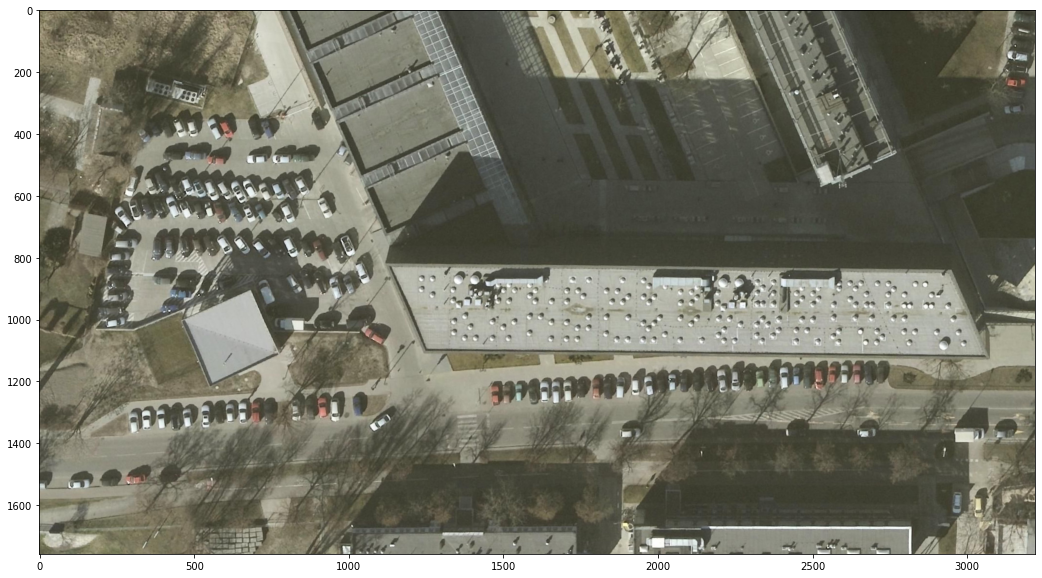

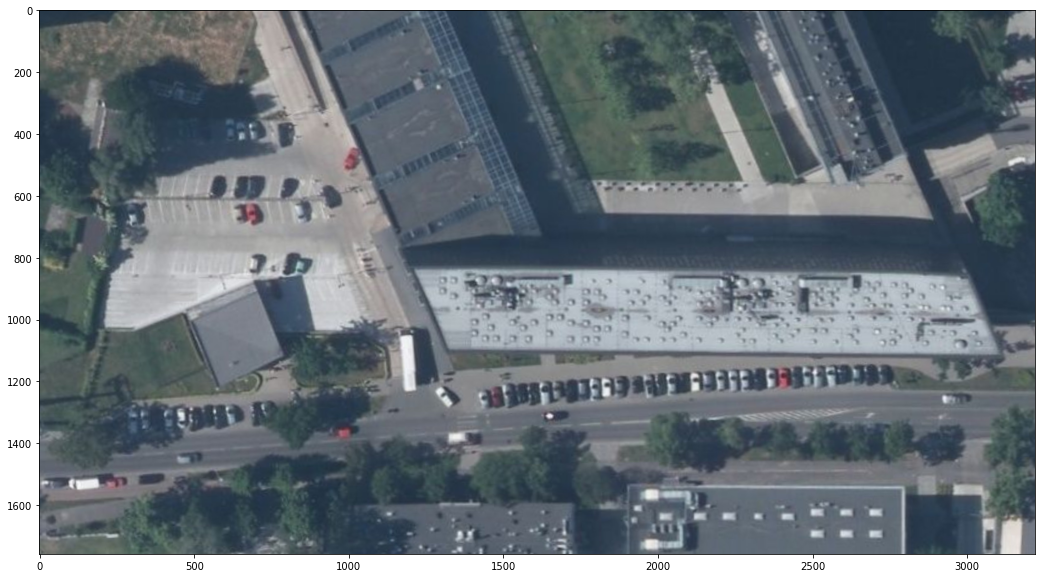

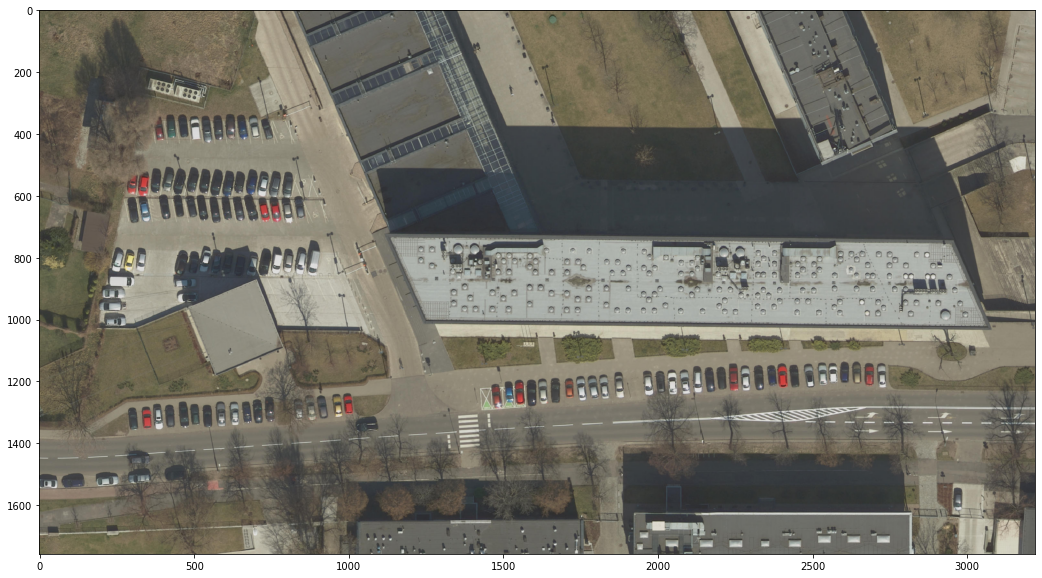

In [ ]:
for i in range(3):
    plt.figure(figsize=(20,10))
    plt.imshow(images[i].image)
    plt.show()

In [ ]:
masks = []
for i in range(3):
    (im, bb) = slider_detector(deepcopy(images[i]), WORKERS, True)
    masks.append(get_mask(im, bb))

(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(925, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(925, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(926, 128, 128, 3)
(925, 128, 128, 3)


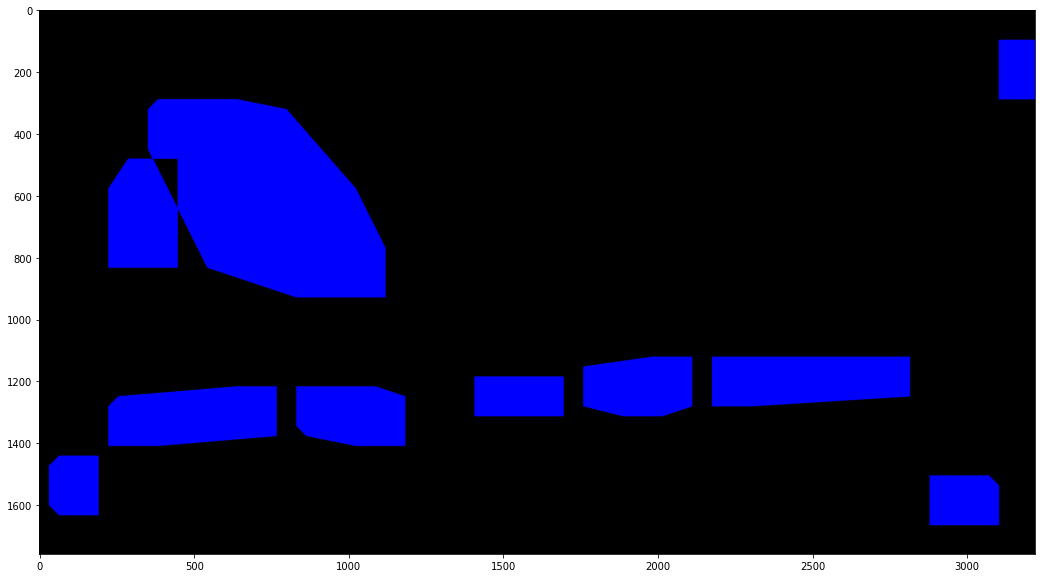

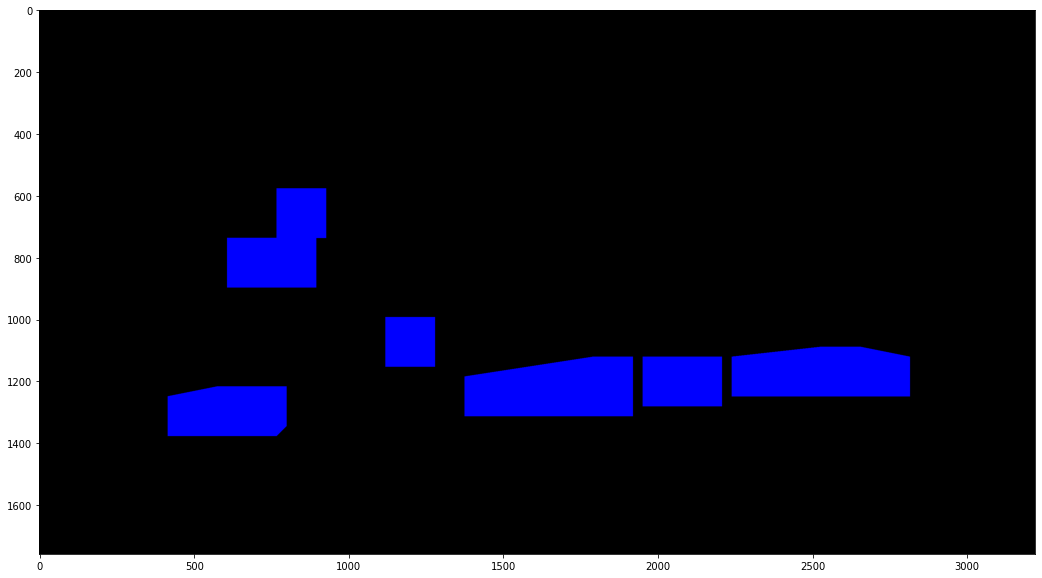

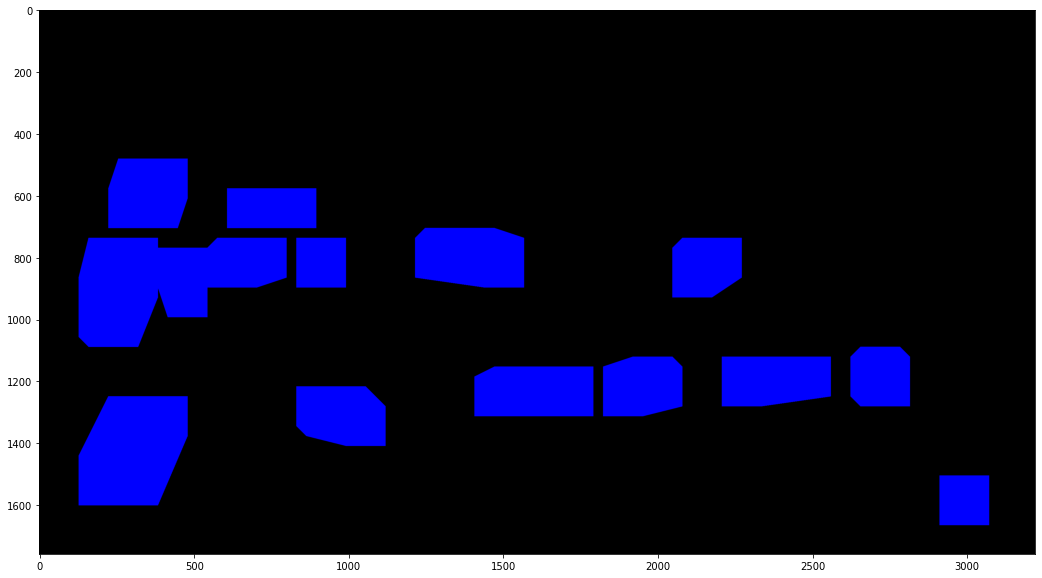

In [ ]:
for i in range(3):
    plt.figure(figsize=(20,10))
    plt.imshow(masks[i])
    plt.show()

In [ ]:
union = np.zeros_like(image)
image_with_mask = images[0].image
t = [0, 0, 255]

for i in tqdm(range(union.shape[0])):
    for j in range(union.shape[1]):

        if (list(masks[0][i][j]) == t) and (list(masks[1][i][j]) == t) and (list(masks[2][i][j]) == t):
            union[i][j] = np.array(t)
            image_with_mask[i][j] = np.array(t)

100%|██████████| 1758/1758 [00:43<00:00, 40.64it/s]


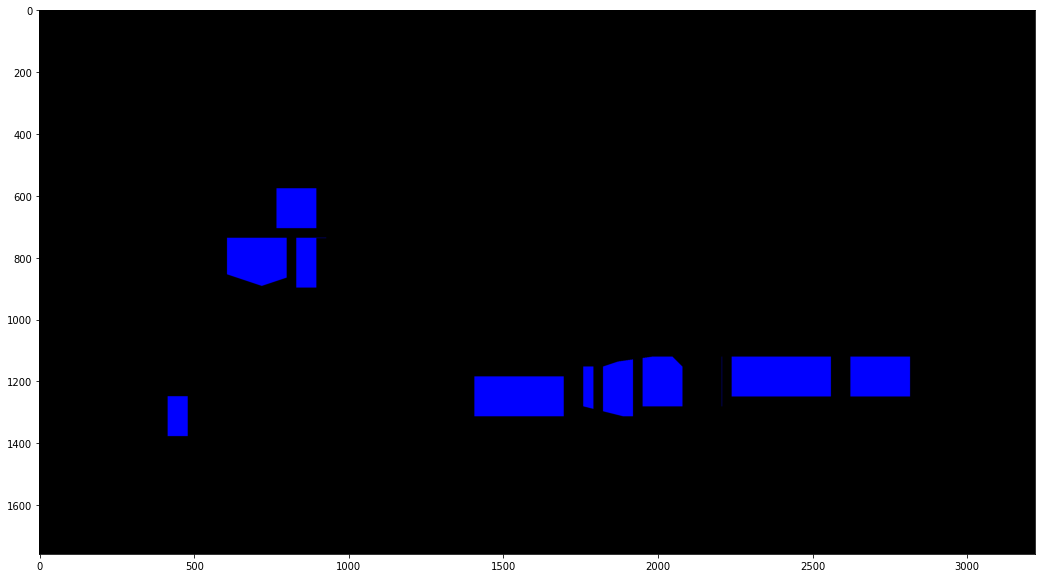

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(union)
plt.show()

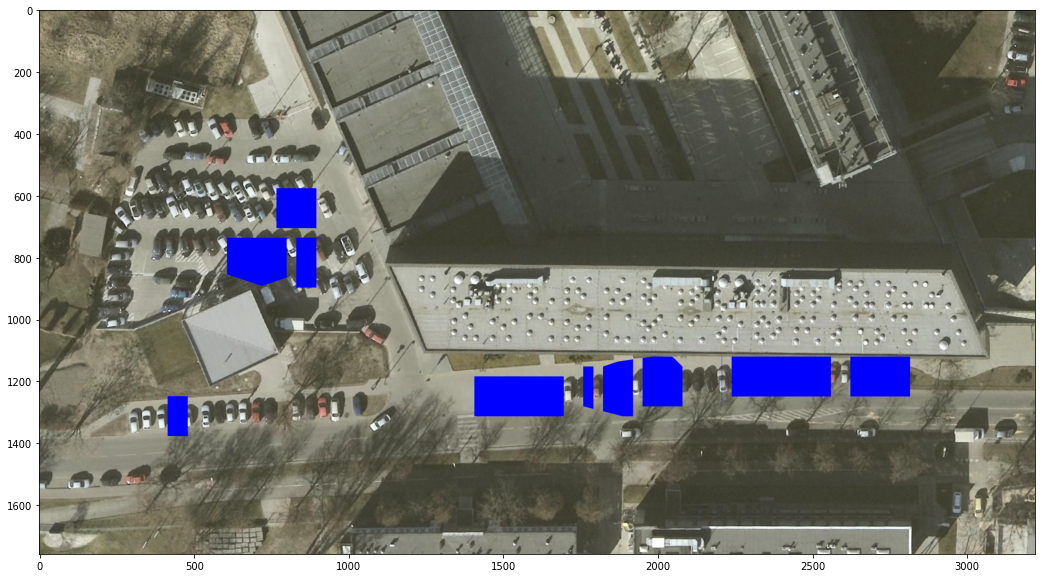

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(image_with_mask)
plt.show()